In [3]:
from google.cloud import bigquery
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="bqexercise.json"
client = bigquery.Client()

In [6]:
# Constructing a reference to the 'SEC' dataset

df_ref = client.dataset('sec_quarterly_financials', project = 'bigquery-public-data')

In [7]:
# Building API request

dataset = client.get_dataset(df_ref)

In [8]:
# List tables in 'hacker news' dataset

tables = list(client.list_tables(dataset))
list_of_tables = [table.table_id for table in tables] 

In [9]:
print(list_of_tables)

['calculation', 'dimension', 'measure_tag', 'numbers', 'presentation', 'quick_summary', 'rendering', 'sic_codes', 'submission', 'txt']


In [16]:
# Building reference to the quick_summary table: 
table_ref = df_ref.table('quick_summary')

# API request: fetch the table.
table = client.get_table(table_ref)

In [17]:
table.schema

[SchemaField('submission_number', 'STRING', 'REQUIRED', 'Accession Number. The 20-character string formed from the 18-digit number assigned by the Commission to each EDGAR submission. submission_number: [adsh]', (), ()),
 SchemaField('company_name', 'STRING', 'NULLABLE', 'Name of registrant from the submission table. This corresponds to the name of the legal entity as recorded in EDGAR as of the filing date.', (), ()),
 SchemaField('measure_tag', 'STRING', 'REQUIRED', 'The unique identifier (name) for a tag in a specific taxonomy release. measure_tag: [tag]', (), ()),
 SchemaField('period_end_date', 'STRING', 'REQUIRED', 'The end date for the data value, rounded to the nearest month end. period_end_date: [ddate]', (), ()),
 SchemaField('value', 'FLOAT', 'NULLABLE', 'The value. This is not scaled, it is as found in the Interactive Data file, but is rounded to four digits to the right of the decimal point.', (), ()),
 SchemaField('units', 'STRING', 'REQUIRED', 'The unit of measure for th

In [18]:
# Previewing the first five lines of the "quick_summary" table:

client.list_rows(table, max_results = 5).to_dataframe()

,submission_number,company_name,measure_tag,period_end_date,value,units,number_of_quarters,version,central_index_key,ein,sic,fiscal_year_end,form,fiscal_year,fiscal_period_focus,date_filed,date_accepted
0,0001437749-17-000102,NATIONAL HOLDINGS CORP,Liabilities,20160930,34773000.0,USD,0,us-gaap/2016,1023844,364128138,6200,0930,S-1/A,2016,FY,20170104,2017-01-04 12:20:00+00:00
1,0001062993-17-000442,"XIANGTIAN (USA) AIR POWER CO., LTD.",CostOfGoodsSold,20140731,0.0,USD,4,us-gaap/2015,1472468,980632932,3621,0731,POS AM,2017,Q1,20170131,2017-01-30 17:34:00+00:00
2,0001564590-17-000589,SCHLUMBERGER LIMITED/NV,DeferredTaxLiabilitiesPropertyPlantAndEquipment,20161231,79000000.0,USD,0,us-gaap/2016,87347,520684746,1389,1231,10-K,2016,FY,20170125,2017-01-25 11:34:00+00:00
3,0001558370-17-000064,HELEN OF TROY LTD,OtherComprehensiveIncomeLossNetOfTaxPortionAtt...,20151130,1805000.0,USD,3,us-gaap/2016,916789,742692550,3634,0229,10-Q,2016,Q3,20170109,2017-01-09 16:00:00+00:00
4,0001674862-17-000006,ASHLAND GLOBAL HOLDINGS INC,DepreciationDepletionAndAmortization,20161231,77000000.0,USD,1,us-gaap/2015,1674862,812587835,5160,0930,10-Q,2017,Q1,20170127,2017-01-27 16:04:00+00:00


In [19]:
# Building reference to the calculation table: 
table_ref_calc = df_ref.table('calculation')

# API request: fetch the table.
table_calc = client.get_table(table_ref_calc)

In [65]:
# Previewing the first five lines of the "calculation" table:

client.list_rows(table_calc, max_results = 5).to_dataframe()

,submission_number,group,arc,negative,parent_tag,parent_version,child_tag,child_version
0,0000277948-09-000066,1,18,1,Assets,us-gaap/2008,Assets,us-gaap/2008
1,0000277948-09-000066,1,29,1,Assets,us-gaap/2008,Assets,us-gaap/2008
2,0000277948-09-000066,1,30,1,Assets,us-gaap/2008,Assets,us-gaap/2008
3,0000277948-09-000066,1,25,1,Assets,us-gaap/2008,Assets,us-gaap/2008
4,0000277948-09-000066,1,28,1,Assets,us-gaap/2008,Assets,us-gaap/2008


In [95]:
# Joining the tables

join_query = """
            select qs.company_name, qs.ein, c.group, sum(value) as total_value
            from `bigquery-public-data.sec_quarterly_financials.quick_summary` as qs
            inner join `bigquery-public-data.sec_quarterly_financials.calculation` as c
                on c.submission_number = qs.submission_number
            where fiscal_year = 2017
            group by qs.company_name, qs.ein, c.group
            order by total_value DESC
            limit 10000
            """

In [96]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(join_query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
join_sec = query_job.to_dataframe()

In [97]:
join_sec

,company_name,ein,group,total_value
0,"CREATIVE REALITIES, INC.",411967918,2,1.069411e+19
1,"CREATIVE REALITIES, INC.",411967918,3,1.069411e+19
2,"CREATIVE REALITIES, INC.",411967918,1,8.713716e+18
3,WOORI BANK,000000000,4,1.019612e+18
4,KB FINANCIAL GROUP INC.,000000000,5,9.551098e+17
...,...,...,...,...
9995,BRITISH TELECOMMUNICATIONS PLC /ADR,000000000,11,2.942280e+13
9996,INTERNATIONAL PAPER CO /NEW/,130872805,4,2.942200e+13
9997,REALTY INCOME CORP,330580106,9,2.940657e+13
9998,DELL TECHNOLOGIES INC,800890963,11,2.940638e+13


In [98]:
join_sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company_name  10000 non-null  object 
 1   ein           10000 non-null  object 
 2   group         10000 non-null  int64  
 3   total_value   10000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 312.6+ KB


In [104]:
join_sec.describe()

,group,total_value
count,10000.000000,1.000000e+04
mean,14.627500,8.689749e+15
std,11.737663,1.785041e+17
min,1.000000,2.940173e+13
25%,5.000000,4.896518e+13
50%,12.000000,1.022070e+14
75%,21.000000,3.493690e+14
max,74.000000,1.069411e+19


In [105]:
join_sec.sort_values(by = 'total_value', inplace = True, ascending = False)

In [106]:
join_sec.reset_index(inplace = True, drop = True)

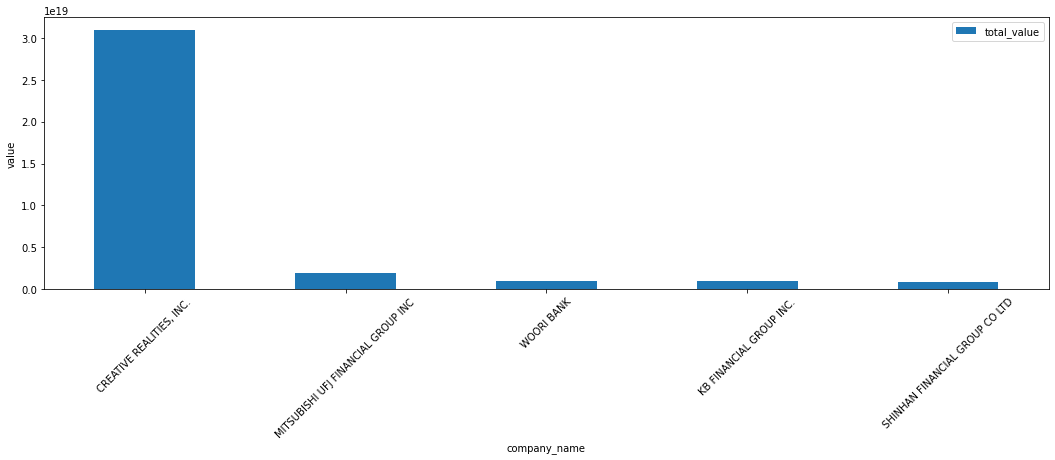

In [107]:
join_sec[['company_name', 'total_value']][:10].groupby('company_name').sum().sort_values(by = 'total_value', ascending = False).plot(kind = 'bar',
                                                                                  figsize=(18,5),
                                                                                  ylabel = 'value',
                                                                                  rot = 45);

In [109]:
join_sec['group'].value_counts()

1     554
2     518
4     496
3     490
5     487
     ... 
71      1
65      1
70      1
69      1
73      1
Name: group, Length: 74, dtype: int64

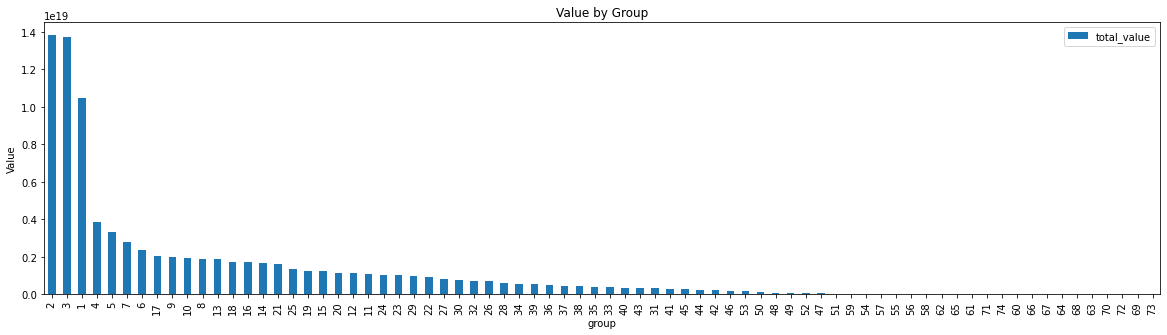

In [113]:
join_sec[['group', 'total_value']].groupby('group').sum().sort_values(by = 'total_value', ascending = False).plot(kind = 'bar',
                                                                                                                 figsize = (20,5),
                                                                                                                 ylabel = 'Value',
                                                                                                                 title = 'Value by Group');